In [27]:
import pandas as pd
import os
from pathlib import Path


# Definir nombre del conjunto de datos
dataset_name = 'derby-10.5.1.1'

# Nombre del metodo de balanceo
method_name = "csbboost"

# Directorio base de salida para este método
output_dir = Path("..") / "classification" / method_name

# Crear la carpeta (y padres) si no existen
output_dir.mkdir(parents=True, exist_ok=True)

print("Directorio de salida:", output_dir.resolve())

# Carga del archivo CSV
df = pd.read_csv(f"../datasets/{dataset_name}.csv")

# Eliminar columnas que no se usarán como predictores
df = df.drop(columns=['HeuBug', 'HeuBugCount', 'RealBugCount'])

Directorio de salida: /Users/behero/Documents/SCHOOL/UTM/MIS/2025/TERCER-SEMESTRE/prediccion-de-errores-en-la-ingenieria-de-software/código/jira-classification-pipeline/classification/csbboost


### Split Train/Test 80/20

In [28]:
import numpy as np

# Eliminar la columna objetivo y la ruta de archivo (File)
X = df.drop(columns=['RealBug', 'File'], errors='ignore')

# Quedarse solo con columnas numéricas (evita problemas con KMeans/SMOTE)
X = X.select_dtypes(include=[np.number]) 

# Variable objetivo: RealBug (0 = no defectuoso, 1 = defectuoso)
y = df['RealBug'].astype(int)

from sklearn.model_selection import train_test_split

# Dividir el conjunto en entrenamiento y prueba manteniendo la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Asegurar que en train/test solo haya numéricas (por si acaso)
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])

In [29]:
# Tamaño del train y tamaño del test
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (2164, 65)
Tamaño del conjunto de prueba: (541, 65)


## Balanceo de clases usando CSBBOOST

### Definir Función CSBBOOST

In [30]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# -------------------------------------------------
# Utilidad: elegir K óptimo con Silhouette
# -------------------------------------------------
def choose_optimal_k(X, k_min=2, k_max=10, random_state=42):
    """
    Elige el número de clústeres K maximizando el Silhouette score.
    """
    n_samples = X.shape[0]
    # Asegurar que haya suficientes muestras
    k_max = min(k_max, n_samples - 1)
    if k_max < k_min:
        return 1  # sin clustering

    best_k = k_min
    best_score = -1

    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k

    return best_k


# -------------------------------------------------
# Utilidad: SMOTE simple dentro de UN clúster
# -------------------------------------------------
def smote_cluster(X_cluster, n_synth, k_neighbors=5, random_state=42):
    """
    Genera n_synth muestras sintéticas a partir de un conjunto de puntos (solo minoría)
    usando la idea básica de SMOTE (interpolación entre vecinos cercanos).
    X_cluster: np.ndarray de shape (n_samples, n_features)
    """
    rng = np.random.default_rng(random_state)

    n_samples, n_features = X_cluster.shape
    if n_synth <= 0 or n_samples < 2:
        return np.empty((0, n_features))  # nada que generar

    k = min(k_neighbors, n_samples - 1)
    nn = NearestNeighbors(n_neighbors=k + 1)  # incluye el propio punto
    nn.fit(X_cluster)
    distances, indices = nn.kneighbors(X_cluster)

    synth = []
    for _ in range(n_synth):
        i = rng.integers(0, n_samples)          # punto base
        # vecinos (ignorando el propio en posición 0)
        neighbors = indices[i, 1:]
        j = rng.choice(neighbors)               # vecino aleatorio
        lam = rng.random()                      # λ ~ U(0, 1)
        x_new = X_cluster[i] + lam * (X_cluster[j] - X_cluster[i])
        synth.append(x_new)

    return np.array(synth)


# -------------------------------------------------
# CSBBoost: balanceo por clúster (solo TRAIN)
# -------------------------------------------------
def csbboost_resample(X_train, y_train, k_neighbors=5,
                      k_range_major=(2, 10), k_range_minor=(2, 10),
                      random_state=42):
    """
    Implementación del esquema de balanceo del paper CSBBoost sobre el conjunto de entrenamiento.
    - X_train: DataFrame o ndarray solo con variables predictoras
    - y_train: Serie / array binario (0/1)
    Devuelve: X_train_bal, y_train_bal (DataFrame, Serie)
    """

    # Aseguramos DataFrame / Serie para mantener nombres de columnas
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)
    if not isinstance(y_train, (pd.Series, pd.DataFrame)):
        y_train = pd.Series(y_train)

    # -------------------------------------------------
    # 1) Identificar clase mayoritaria / minoritaria
    # -------------------------------------------------
    counts = y_train.value_counts()
    maj_label = counts.idxmax()
    min_label = counts.idxmin()

    X_maj = X_train[y_train == maj_label].to_numpy()
    X_min = X_train[y_train == min_label].to_numpy()

    N      = X_train.shape[0]
    N_ma   = X_maj.shape[0]
    N_mi   = X_min.shape[0]

    print(f"\nCSBBoost - distribución original en train:")
    print(f"  Mayoritaria ({maj_label}): {N_ma}")
    print(f"  Minoritaria ({min_label}): {N_mi}")
    print(f"  Total N: {N}")

    rng = np.random.default_rng(random_state)

    # =================================================
    # MAYORÍA: clustering + undersampling proporcional
    # =================================================
    # Elegir K para mayoría
    K_maj = choose_optimal_k(X_maj, k_min=k_range_major[0],
                             k_max=k_range_major[1],
                             random_state=random_state)
    print(f"\n[Mayoría] K óptimo (Silhouette) = {K_maj}")

    kmeans_maj = KMeans(n_clusters=K_maj, random_state=random_state, n_init=10)
    labels_maj = kmeans_maj.fit_predict(X_maj)

    maj_samples_list = []

    for i in range(K_maj):
        idx_i = np.where(labels_maj == i)[0]
        O_i = len(idx_i)                 # tamaño del clúster i
        if O_i == 0:
            continue
        w_i = O_i / N_ma                 # peso relativo
        s_i = int(round(w_i * N / 2))    # tamaño de muestra deseado
        s_i = min(s_i, O_i)              # no podemos tomar más de los que hay

        chosen = rng.choice(idx_i, size=s_i, replace=False)
        maj_samples_list.append(X_maj[chosen, :])

    X_maj_merged = np.vstack(maj_samples_list)
    y_maj_merged = np.full(X_maj_merged.shape[0], maj_label)

    print(f"[Mayoría] Tamaño después de undersampling clusterizado: {X_maj_merged.shape[0]}")

    # =================================================
    # MINORÍA: clustering + SMOTE por clúster
    # =================================================
    K_min = choose_optimal_k(X_min, k_min=k_range_minor[0],
                             k_max=k_range_minor[1],
                             random_state=random_state)
    print(f"\n[Minoría] K' óptimo (Silhouette) = {K_min}")

    kmeans_min = KMeans(n_clusters=K_min, random_state=random_state, n_init=10)
    labels_min = kmeans_min.fit_predict(X_min)

    synth_list = []

    for i in range(K_min):
        idx_i = np.where(labels_min == i)[0]
        O_i_prime = len(idx_i)          # tamaño del clúster i (minoría)
        if O_i_prime == 0:
            continue

        w_i_prime = O_i_prime / N_mi
        s_i_prime = int(round(w_i_prime * N / 2)) - O_i_prime  # fórmula del paper
        if s_i_prime <= 0:
            continue  # este clúster ya tiene suficientes ejemplos

        X_cluster = X_min[idx_i, :]
        synth_i = smote_cluster(X_cluster, n_synth=s_i_prime,
                                k_neighbors=k_neighbors,
                                random_state=random_state)
        synth_list.append(synth_i)

    if len(synth_list) > 0:
        X_min_synth = np.vstack(synth_list)
        y_min_synth = np.full(X_min_synth.shape[0], min_label)
    else:
        X_min_synth = np.empty((0, X_min.shape[1]))
        y_min_synth = np.array([], dtype=y_train.dtype)

    print(f"[Minoría] Nuevas muestras sintéticas generadas: {X_min_synth.shape[0]}")

    # Minoría final: originales + sintéticas
    X_min_final = np.vstack([X_min, X_min_synth])
    y_min_final = np.full(X_min_final.shape[0], min_label)

    print(f"[Minoría] Tamaño final (original + sintético): {X_min_final.shape[0]}")

    # =================================================
    # Mezclar mayoría y minoría → balanced training data
    # =================================================
    X_bal = np.vstack([X_maj_merged, X_min_final])
    y_bal = np.concatenate([y_maj_merged, y_min_final])

    # Convertir de vuelta a DataFrame / Serie, manteniendo nombres de columnas
    X_bal_df = pd.DataFrame(X_bal, columns=X_train.columns)
    y_bal_sr = pd.Series(y_bal, name=y_train.name if y_train.name else "target")

    # Barajar (shuffle)
    perm = rng.permutation(len(y_bal_sr))
    X_bal_df = X_bal_df.iloc[perm].reset_index(drop=True)
    y_bal_sr = y_bal_sr.iloc[perm].reset_index(drop=True)

    print(f"\n✅ CSBBoost balanceo terminado.")
    print(f"   Tamaño final train balanceado: {X_bal_df.shape[0]}")
    print(f"   Distribución clases: \n{y_bal_sr.value_counts()}")

    return X_bal_df, y_bal_sr

In [31]:
# Aplicar CSBBoost al conjunto de entrenamiento
X_train_balanced, y_train_balanced = csbboost_resample(
    X_train,
    y_train,
    k_neighbors=5,
    k_range_major=(2, 10),
    k_range_minor=(2, 10),
    random_state=42
)


CSBBoost - distribución original en train:
  Mayoritaria (0): 1858
  Minoritaria (1): 306
  Total N: 2164

[Mayoría] K óptimo (Silhouette) = 2
[Mayoría] Tamaño después de undersampling clusterizado: 1082

[Minoría] K' óptimo (Silhouette) = 2
[Minoría] Nuevas muestras sintéticas generadas: 776
[Minoría] Tamaño final (original + sintético): 1082

✅ CSBBoost balanceo terminado.
   Tamaño final train balanceado: 2164
   Distribución clases: 
RealBug
0    1082
1    1082
Name: count, dtype: int64


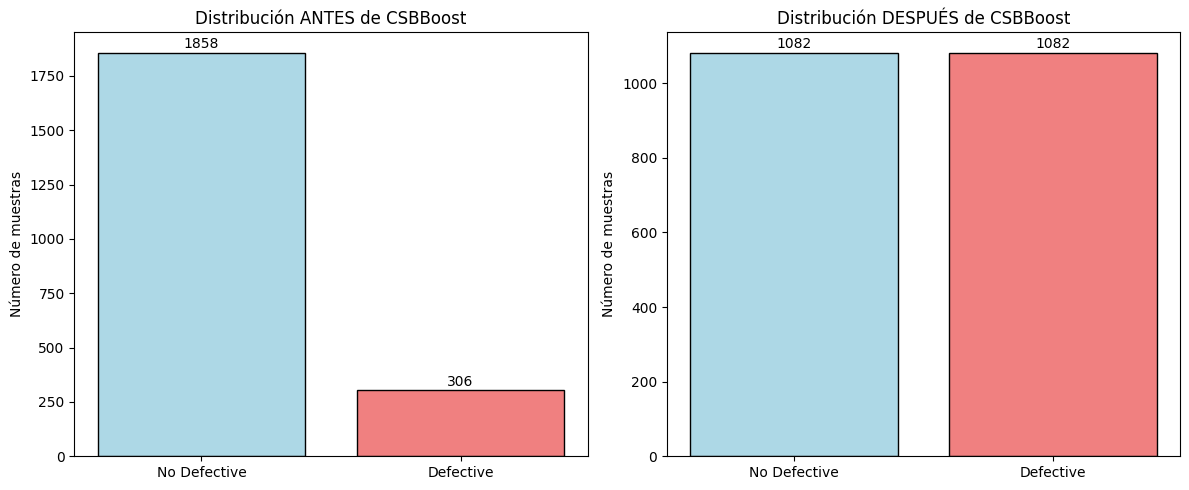


Verificación de calidad de datos balanceados:
Valores nulos en X_train_balanced: 0
Valores infinitos en X_train_balanced: 0
Shape final X_train_balanced: (2164, 65)
Shape final y_train_balanced: (2164,)


In [32]:
# Visualización de la distribución antes y después del balanceo
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Antes del balanceo
before_counts = y_train.value_counts().sort_index()
bars1 = ax1.bar(['No Defective', 'Defective'], before_counts.values, 
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax1.set_title('Distribución ANTES de CSBBoost')
ax1.set_ylabel('Número de muestras')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Después del balanceo
after_counts = y_train_balanced.value_counts().sort_index()
bars2 = ax2.bar(['No Defective', 'Defective'], after_counts.values,
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax2.set_title('Distribución DESPUÉS de CSBBoost')
ax2.set_ylabel('Número de muestras')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Verificar que no hay valores nulos en los datos balanceados
print(f"\nVerificación de calidad de datos balanceados:")
print(f"Valores nulos en X_train_balanced: {X_train_balanced.isnull().sum().sum()}")
print(f"Valores infinitos en X_train_balanced: {np.isinf(X_train_balanced.values).sum()}")
print(f"Shape final X_train_balanced: {X_train_balanced.shape}")
print(f"Shape final y_train_balanced: {y_train_balanced.shape}")

### Normalización

In [33]:
from sklearn.preprocessing import StandardScaler

# Ajustar scaler con el train balanceado y transformar train/test
scaler = StandardScaler()
X_train_balanced_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_balanced),
    columns=X_train_balanced.columns,
    index=X_train_balanced.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numeric),
    columns=X_test_numeric.columns,
    index=X_test_numeric.index
)

In [34]:
X_train_balanced.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,...,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.0,2164.000000,2164.000000,2164.000000
mean,3.281495,15.310348,603.244726,8.018306,2.011496,1.219184,3.639102,58.057733,2.360051,25.724423,...,0.479020,0.297543,24.292489,3.877805,0.856559,0.227291,0.0,1.829376,0.297543,1.866069
std,8.781814,42.107614,956.950763,10.126782,4.995028,0.711105,13.099339,105.773558,1.920514,75.640528,...,1.264984,0.545936,152.194611,21.693290,0.155551,0.383443,0.0,0.961569,0.545936,2.199187
min,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.227656,0.000000,0.0,1.000000,0.000000,0.000000
25%,0.000000,5.000000,120.000000,2.000000,0.000000,1.000000,0.000000,8.000000,1.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.787144,0.000000,0.0,1.000000,0.000000,0.000000
50%,0.591991,10.000000,244.500000,5.000000,0.000000,1.000000,0.000000,21.000000,2.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.913781,0.000000,0.0,1.921075,0.000000,1.000000
75%,2.666463,16.438846,676.201984,10.000000,1.580441,1.000000,2.583945,62.825386,3.000000,27.000000,...,0.566399,0.494122,2.970271,0.000000,0.974922,0.378907,0.0,2.000000,0.494122,3.000000
max,155.000000,895.000000,10134.000000,79.000000,78.000000,11.000000,324.000000,1285.000000,23.000000,1679.000000,...,20.000000,5.000000,3487.000000,407.000000,1.000000,1.000000,0.0,7.000000,5.000000,15.000000


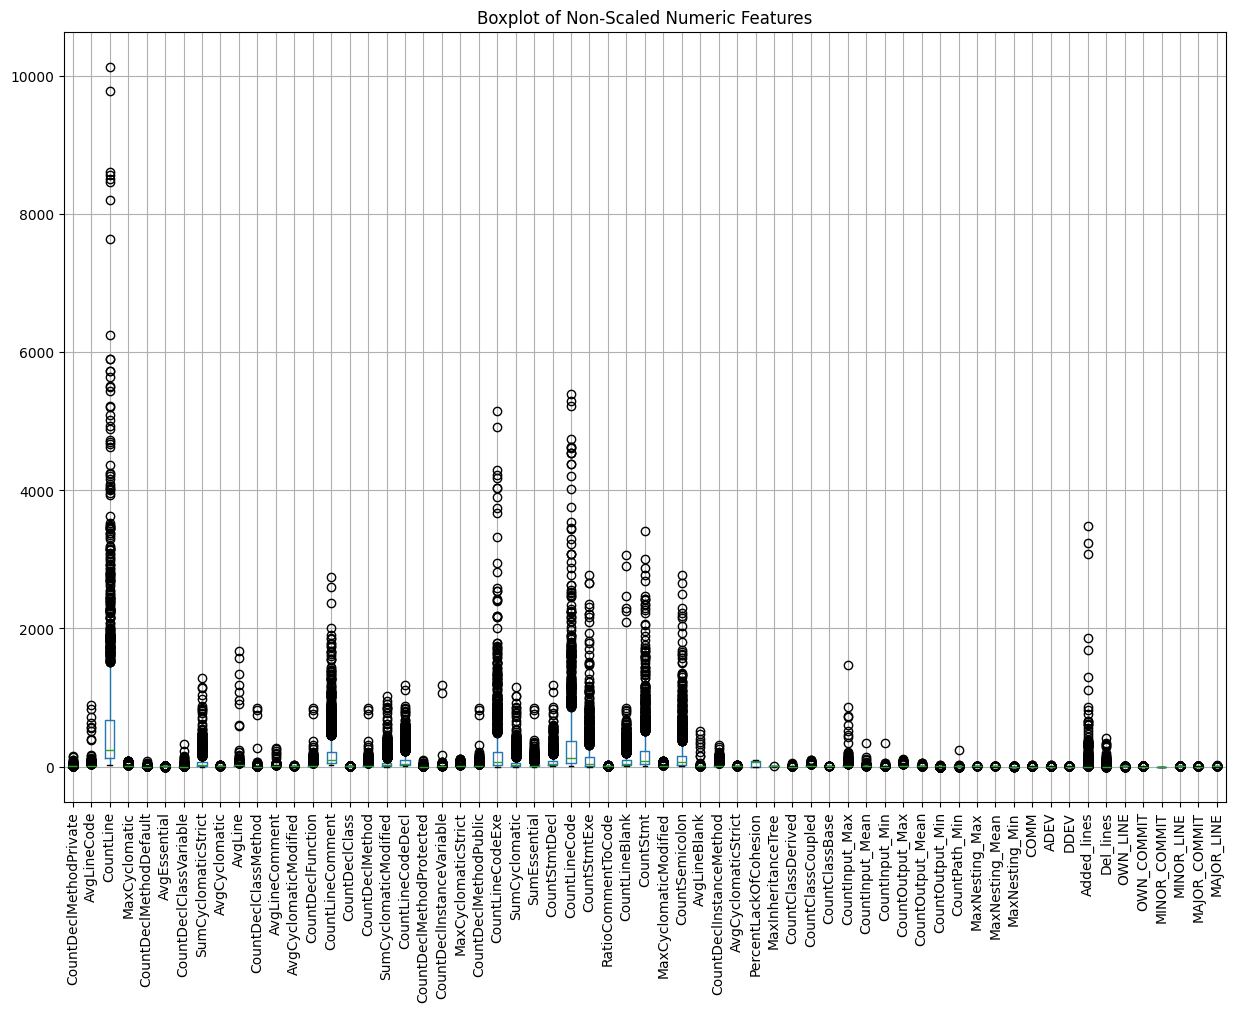

In [35]:
# Boxplot de las características SIN escalar (excepto algunas columnas específicas)
plt.figure(figsize=(15, 10))
X_train_balanced.drop(columns=['CountPath_Max', 'CountPath_Mean'], errors='ignore').boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [36]:
X_train_balanced_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,...,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2164.0,2.164000e+03,2.164000e+03,2.164000e+03
mean,1.641735e-17,2.298428e-17,5.253551e-17,-3.283469e-17,-4.925204e-18,-2.790949e-17,3.283469e-18,6.566938e-18,4.268510e-17,1.723821e-17,...,-8.208673e-17,5.253551e-17,3.078252e-18,-1.641735e-17,-3.841659e-16,1.108171e-17,0.0,6.074418e-17,5.253551e-17,3.283469e-18
std,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,...,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,0.0,1.000231e+00,1.000231e+00,1.000231e+00
min,-3.737557e-01,-3.636845e-01,-6.064877e-01,-7.919751e-01,-4.027928e-01,-1.714889e+00,-2.778723e-01,-5.490139e-01,-1.229148e+00,-3.401664e-01,...,-3.787644e-01,-5.451397e-01,-1.596515e-01,-1.787973e-01,-4.044012e+00,-5.928990e-01,0.0,-8.627230e-01,-5.451397e-01,-8.487227e-01
25%,-3.737557e-01,-2.449137e-01,-5.051006e-01,-5.944334e-01,-4.027928e-01,-3.083018e-01,-2.778723e-01,-4.733631e-01,-7.083340e-01,-2.079316e-01,...,-3.787644e-01,-5.451397e-01,-1.596515e-01,-1.787973e-01,-4.463600e-01,-5.928990e-01,0.0,-8.627230e-01,-5.451397e-01,-8.487227e-01
50%,-3.063291e-01,-1.261429e-01,-3.749698e-01,-2.981207e-01,-4.027928e-01,-3.083018e-01,-2.778723e-01,-3.504307e-01,-1.875197e-01,-1.153673e-01,...,-3.787644e-01,-5.451397e-01,-1.596515e-01,-1.787973e-01,3.679476e-01,-5.928990e-01,0.0,9.538560e-02,-5.451397e-01,-3.939042e-01
75%,-7.005090e-02,2.680653e-02,7.625692e-02,1.957337e-01,-8.631694e-02,-3.083018e-01,-8.056909e-02,4.508456e-02,3.332946e-01,1.686757e-02,...,6.909107e-02,3.601612e-01,-1.401308e-01,-1.787973e-01,7.610991e-01,3.955001e-01,0.0,1.774842e-01,3.601612e-01,5.157328e-01
max,1.728044e+01,2.089629e+01,9.961806e+00,7.010924e+00,1.521635e+01,1.375758e+01,2.446192e+01,1.160239e+01,1.074958e+01,2.186206e+01,...,1.543537e+01,8.615554e+00,2.275710e+01,1.858710e+01,9.223601e-01,2.015652e+00,0.0,5.378520e+00,8.615554e+00,5.973555e+00


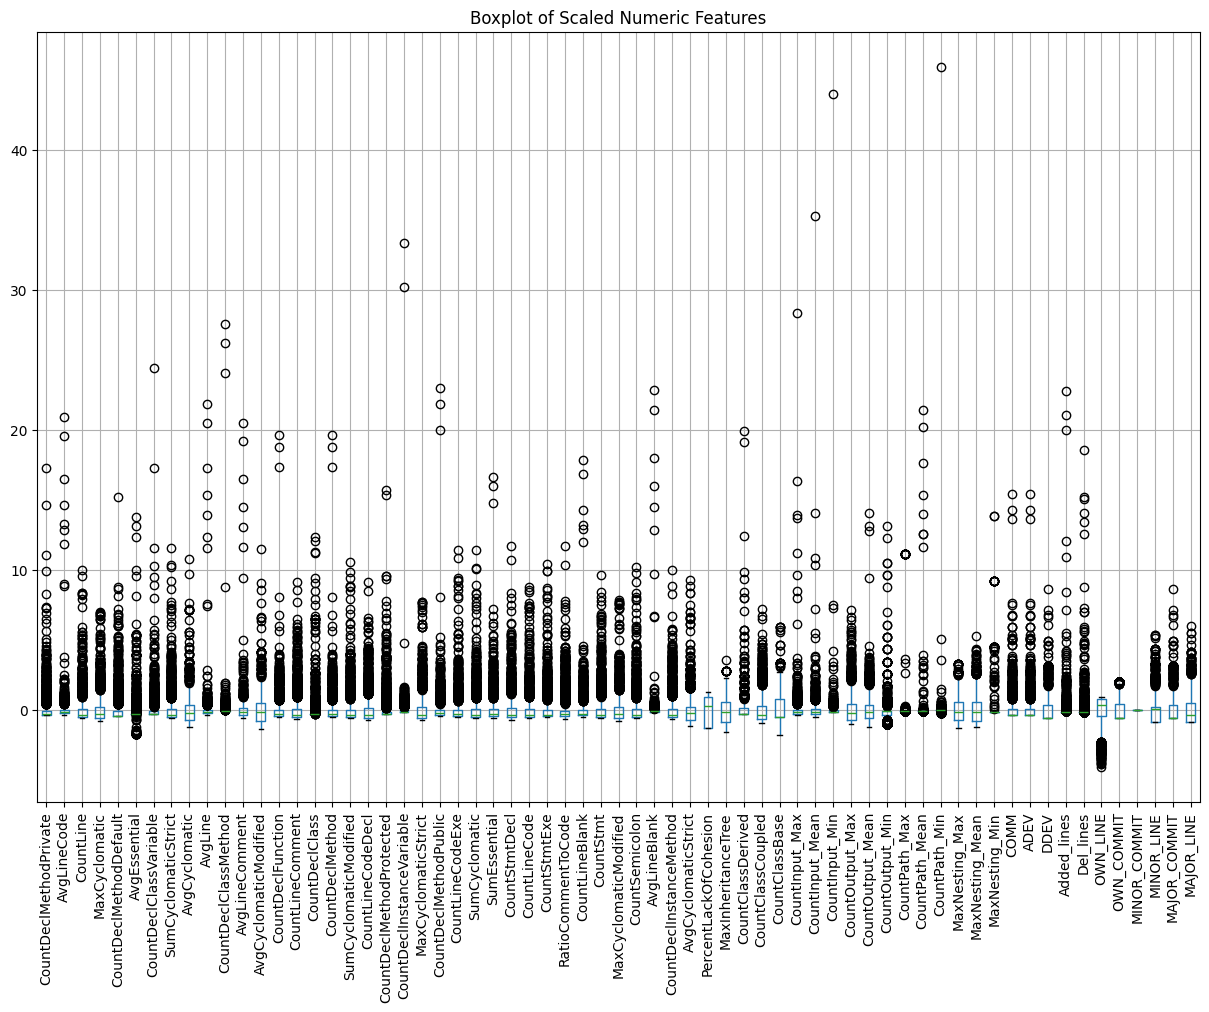

In [37]:
# Boxplot de las características escaladas
plt.figure(figsize=(15, 10))
X_train_balanced_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [38]:
# Exportar conjuntos balanceados/escalados para clasificación

X_train_balanced_scaled.to_csv(
    f"{output_dir}/{dataset_name}-{method_name}-train-features-balanced-scaled.csv",
    index=False,
)

y_train_balanced.to_csv(
    f"{output_dir}/{dataset_name}-{method_name}-train-labels-balanced.csv",
    index=False,
)

X_test_scaled.to_csv(
    f"{output_dir}/{dataset_name}-{method_name}-test-features-scaled.csv",
    index=False,
)

y_test.to_csv(
    f"{output_dir}/{dataset_name}-{method_name}-test-labels.csv",
    index=False,
)